<a href="https://colab.research.google.com/github/rjc89/Tutorials/blob/master/face_detection_pipeline_HOG_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogram of Oriented Gradients (HOG)

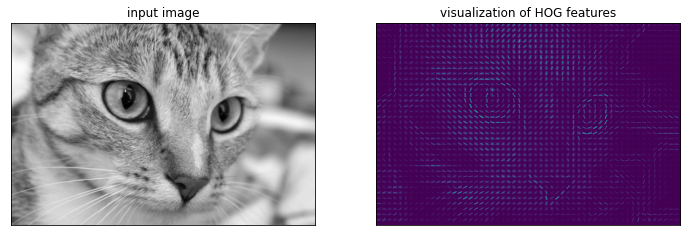

In [9]:
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
import numpy as np

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [5]:
image

array([[0.48523098, 0.48523098, 0.47738784, ..., 0.11692392, 0.11692392,
        0.11692392],
       [0.49699569, 0.49307412, 0.48523098, ..., 0.12336824, 0.1225349 ,
        0.1272898 ],
       [0.50849255, 0.50457098, 0.49475569, ..., 0.12336039, 0.12728196,
        0.13120353],
       ...,
       [0.24786745, 0.29884784, 0.40501294, ..., 0.58914824, 0.58914824,
        0.58914824],
       [0.38173647, 0.42487373, 0.39628392, ..., 0.57403529, 0.57403529,
        0.57795686],
       [0.42487373, 0.36883294, 0.36042431, ..., 0.55442745, 0.55442745,
        0.55834902]])

In [4]:
hog_vec

array([0.02976316, 0.        , 0.        , ..., 0.00032657, 0.        ,
       0.        ])

# Face detection using HOG


In [6]:
# download some images of faces

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [7]:
# obtain negative training images (not-faces)
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [10]:
# use patch extractor to extract thumbnails from them at a variety of scales
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

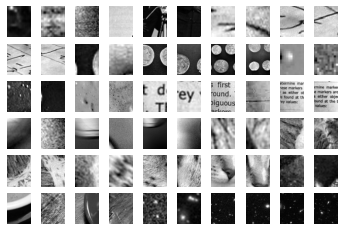

In [11]:
# check out the negative images
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [12]:
# combining the negative and positive training examples and extract HOG features for them ready for sklearn
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [13]:
X_train.shape

(43233, 1215)

# Use an SVM to train a face recognition classifier on the HOG feature set

In [15]:
# train a gaussian naive Bayes as a base model...90% accuracy already
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94784318, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [17]:
# Now train the linear SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9884347176442481

In [18]:
# get the best value of C (regularization parameter (smaller C larger margin, less misclassification))
grid.best_params_

{'C': 1.0}

In [19]:
# grab the best estimator from gridsearchCV and retrain on all the data (not CV)
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Testing face recognition performance


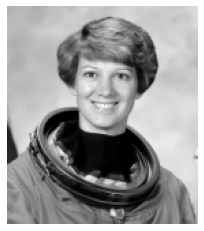

In [20]:
# Load some test images
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [21]:
# convolve a sliding window over the data and extract the HOG features
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [22]:
# then used the extracted HOG features to count the faces in patches
labels = model.predict(patches_hog)
labels.sum()

49.0

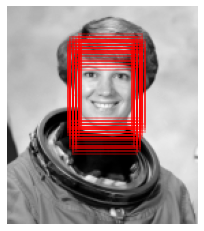

In [23]:
# 49 patches containing faces...lets see where they lie in the image
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

# Limitations of the above method
- Incomplete training set, especially for the negative examples. We could do "hard negative mining" taking false positive patches and using them as labelled negative training examples to retrain on
- The current pipeline, searches only at a 62x47 pixel scale. This can be address with sliding windows of a variety of sizes and resizing with skimage.transform.resize before input to the model
- Overlapping patches should be combined (mean shift clustering or non-maximum supression)
- "many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user. " this dates the book somewhat